# Preparing input data

In [5]:
import pickle
from PIL import Image
import cv2
import os
import random

#creating training data
faces_dir="dataset/trainset/faces"
face_images=os.listdir(faces_dir)
face=[]

for x in face_images:
    im = cv2.imread(faces_dir+"/"+x,0)
    face.append((im,1))
    
non_faces_dir="dataset/trainset/non-faces"
non_face_images=os.listdir(non_faces_dir)
non_face=[]

for x in non_face_images:
    im = cv2.imread(non_faces_dir+"/"+x,0)
    non_face.append((im,0))  
    
input_data = face+non_face
random.shuffle(input_data)
file = open('training_data.pkl', 'wb') 
pickle.dump(input_data, file)
print("DONE")    

DONE


In [6]:
#creating test dataset
faces_dir_test="dataset/testset/faces"
face_images_test=os.listdir(faces_dir_test)
face_test=[]

for x in face_images_test:
    im = cv2.imread(faces_dir_test+"/"+x,0)
    face_test.append((im,1))
    
    
non_faces_dir_test="dataset/testset/non-faces"
non_face_images_test=os.listdir(non_faces_dir_test)
non_face_test=[]

for x in non_face_images_test:
    im = cv2.imread(non_faces_dir_test+"/"+x,0)
    non_face_test.append((im,0)) 
    
input_data_test = face_test+non_face_test
random.shuffle(input_data_test)
file = open('testing_data.pkl', 'wb') 
pickle.dump(input_data_test, file)
print("DONE")    
    

DONE


# Building the model

In [52]:
"""
A Python implementation of the Viola-Jones ensemble classification method described in 
Viola, Paul, and Michael Jones. "Rapid object detection using a boosted cascade of simple features." Computer Vision and Pattern Recognition, 2001. CVPR 2001. Proceedings of the 2001 IEEE Computer Society Conference on. Vol. 1. IEEE, 2001.
Works in both Python2 and Python3
"""
import numpy as np
import math
import pickle

def integral_image(image):
    int_image = np.zeros(image.shape)
    s = np.zeros(image.shape)
    for j in range(len(image)):
        for i in range(len(image[j])):
            s[j][i] = s[j-1][i] + image[j][i] if j-1 >= 0 else image[j][i]
            int_image[j][i] = int_image[j][i-1]+s[j][i] if i-1 >= 0 else s[j][i]
#     if int_image.any():
#         print("True")
#     else:
#         print("False")
    return int_image


def calculate(int_image, i, j, x, y):
    return (int_image[j+y][i+x] + int_image[j][i]) - (int_image[j+y][i] + int_image[j][i+x])


class ViolaJones:
    def __init__(self, r):
        """
          Args:
            T: The number of weak classifiers which should be used
        """
        self.rounds = r
        
        self.alphas = []
        self.polarities=[]
        self.thresholds=[]
        self.feature_coord=[]
        self.classifiers = []
        #self.classifier_index=[]
        self.classifier_type=[]
        self.accuracy=[]
        self.fp=[]
        self.fn=[]

    def feature_extraction(self, training, im_w, im_h):
        flag=0
        type_1, type_2, type_3, type_4, type_5 = 0, 0, 0, 0, 0
        
        self.weights = np.zeros(len(training)) #######
        
        y_data=[]
        p=0
        n=0
        image_height, image_width = im_h, im_w
        for i in range(len(training)): #########
            if training[i][1]==1:
                p+=1
            elif training[i][1]==0:
                n+=1
            y_data.append(training[i][1])    
                
        features=[]
        for q in range(len(training)): ###########
            self.weights[q]=1/(2*p) if training[q][1]==1 else 1/(2*n)
            intermediate_1 = integral_image(training[q][0])
            image_features = []
            for i in range(1, image_width+1):
                for j in range(1, image_height+1):
                    w = 0
                    while i + w  < image_width and w<9:
                        h = 0
                        while j + h < image_height and h<9:
                            current = calculate(intermediate_1, i, j, w, h)
                            #2 horizontal
                            if i+2*w < image_width:
                                horizontal_1 = calculate(intermediate_1, i+w, j, w, h)
                                image_features.append(horizontal_1-current)
                                if not flag:
                                    type_2+=1
                                    self.feature_coord.append(("Two Horizontal",[[i+w, j, w, h]], [[i, j, w, h]]))
                                
                                
                            #2 vertical    
                            if j+2*h < image_height:    
                                vertical_1 = calculate(intermediate_1, i, j+h, w, h)
                                image_features.append(current-vertical_1)
                                if not flag:
                                    type_1+=1
                                    self.feature_coord.append(("Two Vertical",[[i, j, w, h]],[[i, j+h, w, h]]))
                    
                    
                            #4 features    
                            if i+2*w < image_width and j+2*h < image_height:    
                                last = calculate(intermediate_1, i+w, j+h, w, h) 
                                image_features.append((horizontal_1+vertical_1)-(current+last))
                                if not flag:
                                    type_5+=1
                                    self.feature_coord.append(("Four Rectangle",[[i+w, j, w, h],[i, j+h, w, h]],[[i, j, w, h],[i+w, j+h, w, h]]))
                            
                                
                            #3 horizontal      
                            if i+3*w < image_width:    
                                horizontal_2 = calculate(intermediate_1, i+2*w, j, w, h)
                                image_features.append(horizontal_1-(horizontal_2+current))
                                if not flag:
                                    type_3+=1
                                    self.feature_coord.append(("Three Horizontal",[[i+w, j, w, h]],[[i+2*w, j, w, h],[i,j,w,h]]))
                               
                                
                            #3 vertical    
                            if j+3*h < image_height:    
                                vertical_2 = calculate(intermediate_1, i, j+2*h, w, h)
                                image_features.append(vertical_1-(vertical_2+current))
                                if not flag:
                                    type_4+=1
                                    self.feature_coord.append(("Three Vertical",[[i, j+h, w, h]],[[i, j+2*h, w, h],[i,j,w,h]]))
                            

                            h += 1
                        w += 1
            features.append(image_features)
            if not flag:
                print("Type 1: {}, Type 2: {}, Type 3: {}, Type 4: {}, Type 5: {}".format(type_1, type_2, type_3, type_4, type_5))
            flag=1
            
        xx = features
        print("Shape of the data in feature extraction, before transpose is {}".format(np.asarray(xx).shape))
        x_data=list(map(list, zip(*features)))
        print("Shape of the data in feature extraction, after transpose is {},{}".format(len(x_data),len(x_data[0])))
        return x_data, y_data
    
    
    
    
    def training(self, testing, x_data, y_data):
        for r in range(self.rounds):
            w_data=self.weights
            print("Round : {}/{}______________________________________".format(r+1,self.rounds))
            #normalize the weights
            w_data = w_data / np.linalg.norm(w_data)
            
            number_of_features = len(self.feature_coord)
            
            #for selection of classifier
            best_classifier, best_classifier_index, best_classifier_type, best_error, best_accuracy = None, None, None, float('inf'), None
            best_threshold_1, best_polarity_1 = None, None
            
            #calculating weight of positive samples and weight of negative samples
            total_pos=0
            total_neg=0
            for w, y in zip(w_data, y_data):
                if y == 1:
                    total_pos += w
                else:
                    total_neg += w
                    

            #iterating through all the features for every round and choosing the best feature for each round
            for feature_index, feature in enumerate(x_data):  
                feature_sorted = sorted(zip(w_data, feature, y_data), key=lambda x: x[1])
                
                pos_seen, neg_seen = 0, 0
                pos_weights, neg_weights = 0, 0
                min_error, best_feature, best_feature_type, best_threshold, best_polarity = float('inf'), None, None, None, None
                
                #to find parity/polarity and threshold for feature j
                for w, f, y in feature_sorted:
                    error = min(neg_weights + total_pos - pos_weights, pos_weights + total_neg - neg_weights)
                    if error < min_error:
                        min_error = error
                        best_feature_type, best_feature = self.feature_coord[feature_index][0], self.feature_coord[feature_index][1:]
                        best_feature_index = feature_index 
                        best_threshold = f
                        best_polarity = 1 if pos_seen > neg_seen else -1

                    if y == 1:
                        pos_seen += 1
                        pos_weights += w
                    else:
                        neg_seen += 1
                        neg_weights += w
                        
#                 fp_tmp, fn_tmp=0,0
#                 error, accuracy = 0, []
#                 lambda_tmp=0
#                 for ind, w in enumerate(w_data):
#                     if best_polarity*x_data[best_feature_index][ind]<=best_polarity*best_threshold: 
#                         tmp=1
#                     else:
#                         tmp=0
#                     if tmp == 1 and y_data[ind]==0:
#                         fp_tmp+=1
#                     elif tmp==0 and y_data[ind]==1:
#                         fn_tmp+=1
#                     correctness=abs(tmp-y_data[ind])
#                     accuracy.append(correctness)
#                 error=error+(lambda_tmp*fn_tmp)+(1-lambda_tmp)*fp_tmp
#                 #print("FP {} FN {} ERROR {}".format(fp_tmp,fn_tmp,error))    
#                 error = error/len(y_data)   
                    
                      
                #to find error of feature j using it's polarity and threshold       
                error, accuracy = 0, []
                for ind,w in enumerate(w_data):
                    if best_polarity * x_data[best_feature_index][ind] < best_polarity * best_threshold:
                        tmp=1
                    else:
                        tmp=0    
                    correctness = abs(tmp - y_data[ind])
                    accuracy.append(correctness)
                    error += w * correctness    
                error = error / len(y_data)
                  
                
                
                
                #the best classifier among all the classifiers
                if error < best_error:
                    best_classifier, best_classifier_index, best_error, best_accuracy = best_feature, best_feature_index, error, accuracy
                    best_classifier_type = best_feature_type
                    best_threshold_1, best_polarity_1 = best_threshold, best_polarity
                    
                    
            #calculating alpha and beta values for the round
            if best_error==0:
                best_error=0.01
            print("Best Error is {}".format(best_error))    
            beta = best_error / (1.0 - best_error)
            alpha = math.log(1.0/beta)
            
            #weight updation
            for i in range(len(best_accuracy)):
                w_data[i] = w_data[i] * (beta ** (1 - best_accuracy[i]))
                
            #storing the values found in the round    
            self.classifiers.append(best_classifier) 
            self.classifier_type.append(best_classifier_type)
            self.alphas.append(alpha)
            self.thresholds.append(best_threshold_1)
            self.polarities.append(best_polarity_1)
            self.weights=w_data
            print("The chosen classifier of type {} is {} and threshold is {}".format(best_classifier_type, best_classifier, best_threshold_1))
            a,b,c = self.evaluate(testing) #result is printed
            
        return a,b,c 



    
            
    def classify(self, image):
        """
        Classifies an image
          Args:
            image: A numpy 2D array of shape (m, n) representing the image
          Returns:
            1 if the image is positively classified and 0 otherwise
        """
        test_result = 0
        int_image = integral_image(image)
        for alpha, classifier, polarity, threshold in zip(self.alphas, self.classifiers, self.polarities, self.thresholds): #clf=feature index; alpha=alpha
            tmp_pos=0
            tmp_neg=0
            feature_extraction_test=0
            
            for pos_reg in classifier[0]:
                feature_extraction_test += calculate(int_image, pos_reg[0],pos_reg[1],pos_reg[2],pos_reg[3])
            for neg_reg in classifier[1]:
                feature_extraction_test-= calculate(int_image, neg_reg[0], neg_reg[1], neg_reg[2], neg_reg[3])
                
            prediction=0
            if polarity*feature_extraction_test < polarity*threshold:
                prediction=1
            test_result+= alpha * prediction
        return 1 if test_result>=0.5*sum(self.alphas) else 0        
        
                
                    
    def evaluate(self, test_data):
        num_positives = 0
        num_negatives = 0
        
        correct = 0
        false_positives=0
        false_negatives=0
        

        for x, y in test_data: #######
            if y == 1:
                num_positives += 1
            else:
                num_negatives += 1

            pred = self.classify(x)
            if pred == 1 and y == 0:
                false_positives += 1
            if pred == 0 and y == 1:
                false_negatives += 1

            correct += 1 if pred == y else 0
        self.fp.append(false_positives/num_negatives)
        self.fn.append(false_negatives/num_positives)
        self.accuracy.append(correct/len(test_data))
        print("False Positive Rate: %d/%d (%f)" % (false_positives, num_negatives, false_positives/num_negatives))
        print("False Negative Rate: %d/%d (%f)" % (false_negatives, num_positives, false_negatives/num_positives))
        print("Accuracy: %d/%d (%f)" % (correct, len(test_data), correct/len(test_data))) ####### 
        return false_positives, false_negatives, correct/len(test_data)
       
        
req_rounds = [1,3,5,10]
final_accuracy, final_fp, final_fn = [],[],[]

with open("training_data.pkl", 'rb') as f:
    training = pickle.load(f)
    print("Training Data is loaded")
    print("Number of samples is ",len(training))
    
    with open('testing_data.pkl', 'rb') as ff:
        testing = pickle.load(ff)
    
        viola = ViolaJones(10)
        print("Viola object is created for {} rounds".format(10)) 

        x_train_data, y_train_data = viola.feature_extraction(training, 19, 19) #result is stored in the return
        print("Feature extraction is over")

        a,b,c = viola.training(testing, x_train_data, y_train_data) #result is stored in self variables
        print("Tarining is completed")
    
    
#     with open('testing_data.pkl', 'rb') as ff:
#         testing = pickle.load(ff)
        
#         for k in req_rounds:
#             viola = ViolaJones(k)
#             print("Viola object is created for {} rounds".format(k)) 

#             x_train_data, y_train_data = viola.feature_extraction(training, 19, 19) #result is stored in the return
#             print("Feature extraction is over")

#             a,b,c = viola.training(testing, x_train_data, y_train_data) #result is stored in self variables
#             print("Tarining is completed")
#             final_fp.append(a)
#             final_fn.append(b)
#             final_accuracy.append(c)
            
            
        
    
# with open('testing_data.pkl', 'rb') as ff:
#     testing = pickle.load(ff)
#     viola.evaluate(testing) #result is printed

            
            

Training Data is loaded
Number of samples is  2499
Viola object is created for 10 rounds
Type 1: 11340, Type 2: 11340, Type 3: 7938, Type 4: 7938, Type 5: 8100
Shape of the data in feature extraction, before transpose is (2499, 46656)
Shape of the data in feature extraction, after transpose is 46656,2499
Feature extraction is over
Round : 1/10______________________________________
Best Error is 0.057623049219687875
The chosen classifier of type Three Horizontal is ([[11, 11, 2, 1]], [[13, 11, 2, 1], [9, 11, 2, 1]]) and threshold is -68.0
False Positive Rate: 78/2001 (0.038981)
False Negative Rate: 464/472 (0.983051)
Accuracy: 1931/2473 (0.780833)
Round : 2/10______________________________________
Best Error is 0.00040016006402561027
The chosen classifier of type Four Rectangle is ([[2, 1, 1, 2], [1, 3, 1, 2]], [[1, 1, 1, 2], [2, 3, 1, 2]]) and threshold is 196.0
False Positive Rate: 0/2001 (0.000000)
False Negative Rate: 472/472 (1.000000)
Accuracy: 2001/2473 (0.809139)
Round : 3/10___

# Results of training

Round 1/10 
Feature type :  Three Horizontal
Feature (left,top,right,bottom) :  ([[11, 11, 2, 1]], [[13, 11, 2, 1], [9, 11, 2, 1]])
Threshold :  -68.0


Performance Evaluation
Accuracy :  0.7808329963606955
False Positive Rate :  0.038980509745127435
False Negative Rate :  0.9830508474576272
________________________________________________________________________________________________________


Round 2/10 
Feature type :  Four Rectangle
Feature (left,top,right,bottom) :  ([[2, 1, 1, 2], [1, 3, 1, 2]], [[1, 1, 1, 2], [2, 3, 1, 2]])
Threshold :  196.0


Performance Evaluation
Accuracy :  0.8091386979377274
False Positive Rate :  0.0
False Negative Rate :  1.0
________________________________________________________________________________________________________


Round 3/10 
Feature type :  Four Rectangle
Feature (left,top,right,bottom) :  ([[2, 1, 1, 2], [1, 3, 1, 2]], [[1, 1, 1, 2], [2, 3, 1, 2]])
Threshold :  196.0


Performance Evaluation
Accuracy :  0.8091386979377274
False Posit

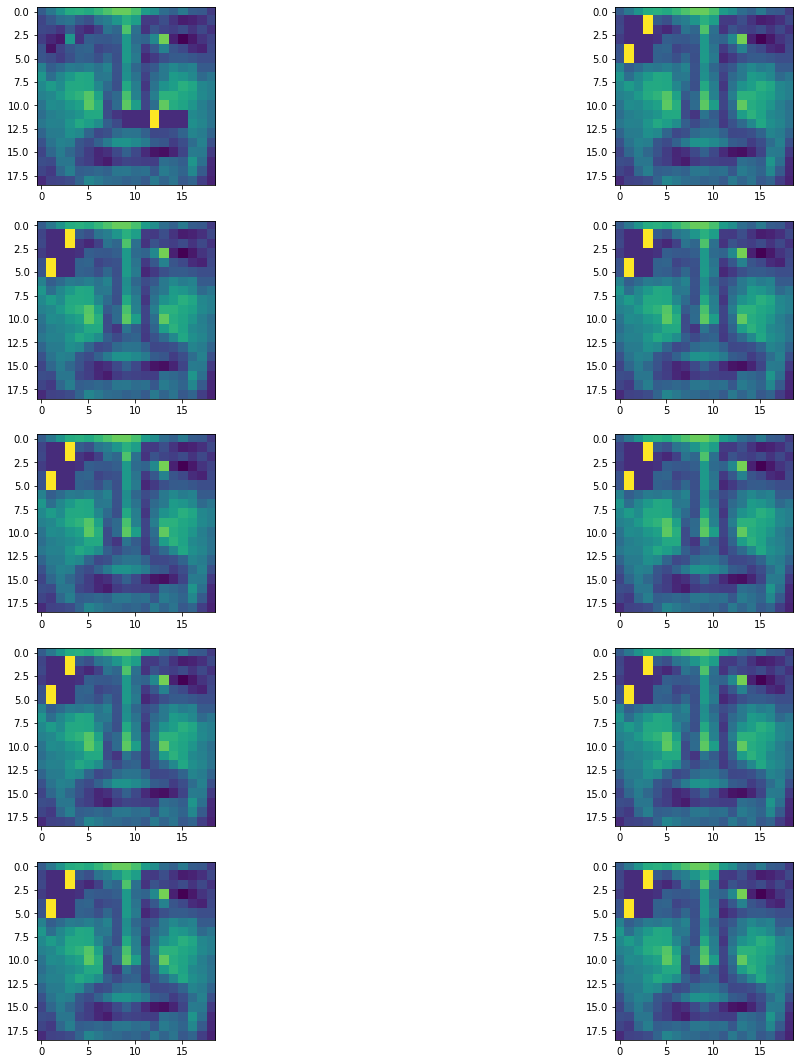

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


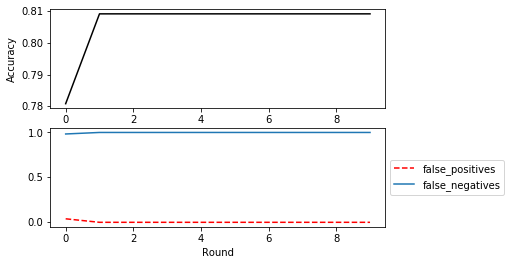

In [53]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

i=0
tmp_image=[]

#img1 = ImageDraw.Draw(report_image)

for alpha, classifier, classifier_type, polarity, threshold in zip(viola.alphas, viola.classifiers, viola.classifier_type,  viola.polarities, viola.thresholds): #clf=feature index; alpha=alpha
    print("Round {}/{} ".format(i+1,10))
    print("Feature type : ",classifier_type)
    print("Feature (left,top,right,bottom) : ", classifier)
    print("Threshold : ", threshold)
    print("\n")
    
    print("Performance Evaluation")
    print("Accuracy : ", viola.accuracy[i])
    print("False Positive Rate : ", viola.fp[i])
    print("False Negative Rate : ", viola.fn[i])
    
    report_image = Image.open('dataset/trainset/faces/face00001.png')
    img1 = ImageDraw.Draw(report_image)
    for pos in classifier[0]:
        shape=[(pos[0],pos[1]),(pos[0]+pos[2],pos[1]+pos[3])]
        img1.rectangle(shape, fill ="yellow")
        
    for neg in classifier[1]:
        shape=[(neg[0],neg[1]),(neg[0]+neg[2],neg[1]+neg[3])]
        img1.rectangle(shape, fill ="red")
    #imshow(np.asarray(report_image))  
    tmp_image.append(np.asarray(report_image))
    
    i+=1
    print("________________________________________________________________________________________________________")
    print("\n")

      
columns = 2
rows = 5
fig = plt.figure(figsize=(19, 19))
for i in range(1,len(tmp_image)+1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(tmp_image[i-1])
plt.show()

x=[]
for i in range(10):
    x.append(i)

plt.figure()
plt.subplot(211)
plt.plot(x, viola.accuracy, 'k')
plt.ylabel('Accuracy')
plt.xlabel("Round")

plt.subplot(212)
plt.plot(x, viola.fp, 'r--', label='false_positives')
plt.xlabel("Round")


plt.subplot(212)
plt.plot(x, viola.fn, label='false_negatives')
#plt.legend(loc="upper right")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Round")

plt.show()
    
    

# Junk

In [6]:
def training(self, testing, x_data, y_data):
        for r in range(self.rounds):
            w_data=self.weights
            print("Round : {}/{}______________________________________".format(r+1,self.rounds))
            #normalize the weights
            w_data = w_data / np.linalg.norm(w_data)
            
            number_of_features = len(self.feature_coord)
            
            #for selection of classifier
            best_classifier, best_classifier_index, best_classifier_type, best_error, best_accuracy = None, None, None, float('inf'), None
            best_threshold_1, best_polarity_1 = None, None
            
            #calculating weight of positive samples and weight of negative samples
            total_pos=0
            total_neg=0
            for w, y in zip(w_data, y_data):
                if y == 1:
                    total_pos += w
                else:
                    total_neg += w
                    
            F_star=float('inf')
            
            #iterating through all the features for every round and choosing the best feature for each round
            for feature_index, feature in enumerate(x_data):
                #feature=feature.tolist()  
                feature_sorted = sorted(zip(w_data, feature, y_data), key=lambda x: x[1])
                F=0
                for i in range(len(y_data)):
                    if y_data[i]==1:
                        F+=w_data[i]
                if F<F_star:
                    F_star=F
                    threshold_star=x_data[feature_index][0] -1
                    parity_star=feature_index
                for j in range(len(y_data)-1):
                    F=F-(y_data[i]*w_data[i])
                    if F<F_star and x_data[feature_index][j]!=x_data[feature_index][j+1]:
                        print("YES")
                        F_star=F
                        threshold_star=0.5*(x_data[feature_index][j]+x_data[feature_index][j+1])
                        parity_star=feature_index
                        feature_star = self.feature_coord[feature_index][1:]
                        best_feature_type = self.feature_coord[feature_index][0]
                    
                      
            #to find error of feature j using it's polarity and threshold       
            error, accuracy = 0, []
            for ind,w in enumerate(w_data):
                if parity_star * x_data[parity_star][ind] <= parity_star * threshold_star:
                    tmp=1
                else:
                    tmp=0
                correctness = abs(tmp - y_data[ind])
                accuracy.append(correctness)
                error += w * correctness    
            #error = error / len(y_data)
            
            
            
#             weight_k = 0.5 * math.log((i/error)-1)
#             denom=0
#             for i in range(len(y_data)):
#                 tmp = 1 if parity_star * x_data[parity_star][i] <= parity_star * threshold_star else 0
#                 denom= denom + w_data[i]*y_data[i]*tmp
#             for i in range(len(y_data)):  
#                 tmp = 1 if parity_star * x_data[parity_star][i] <= parity_star * threshold_star else 0
#                 w_data[i] = (w_data[i]*exp(-w_data[i]*y_data[i]*tmp))/denom




            #the best classifier among all the classifiers
            
            best_classifier, best_classifier_index, best_error, best_accuracy = self.feature_coord[parity_star][1:], parity_star, error, accuracy
            best_classifier_type = self.feature_coord[parity_star][0]
                    
            #calculating alpha and beta values for the round
            if error==0:
                error=0.01
            beta = error / (1.0 - error)
            alpha = math.log(1.0/beta)
            
            #weight updation
            for i in range(len(accuracy)):
                w_data[i] = w_data[i] * (beta ** (1 - accuracy[i]))
                
            #storing the values found in the round    
            self.classifiers.append(best_classifier) 
            self.classifier_type.append(best_classifier_type)
            self.alphas.append(alpha)
            self.thresholds.append(threshold_star)
            self.polarities.append(parity_star)
            self.weights=w_data
            print("The chosen classifier of type {} is {} and threshold is {}".format(best_classifier_type, best_classifier, best_threshold_1))
            a,b,c = self.evaluate(testing) #result is printed
            
        return a,b,c        

In [66]:
if any(x_train_data[0]):
    print("YES")
else:
    print("FALSE")
print(x_train_data)
# l=[[1, 4, 7,10], [2, 5, 8,11], [3, 6, 9,13]]
# list(map(list, zip(*l)))
# print(l)

FALSE
[[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 

([[7, 14, 3, 2], [4, 16, 3, 2]], [[4, 14, 3, 2], [7, 16, 3, 2]])


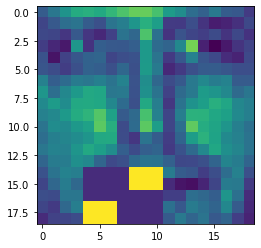

In [49]:
#import cv2
#import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from matplotlib.pyplot import imshow
report_image = Image.open('dataset/trainset/faces/face00001.png')
img1 = ImageDraw.Draw(report_image)
x=viola.classifiers[2]
print(x)
for pos in x[0]:
    shape=[(pos[0],pos[1]),(pos[0]+pos[2],pos[1]+pos[3])]
    img1.rectangle(shape, fill ="yellow")
#imshow(np.asarray(report_image))    
for neg in x[1]:
    shape=[(neg[0],neg[1]),(neg[0]+neg[2],neg[1]+neg[3])]
    img1.rectangle(shape, fill ="red")
imshow(np.asarray(report_image))  



#report_image.show()
##800080
# report_image=cv2.imread('dataset/trainset/faces/face00001.png',0)
# x=viola.classifiers[4]
# print(x)
# for pos in x[0]:
#     cv2.rectangle(report_image, (pos[1],pos[0]), (pos[1]+pos[3], pos[0]+pos[2]),(200, 0, 0),2)    
# for neg in x[1]:
#     cv2.rectangle(report_image, (neg[1],neg[0]), (neg[1]+neg[3], neg[0]+neg[2]),(0, 0, 0),2) 
# plt.imshow(report_image,cmap='gray')
# plt.show()    

([[2, 1, 1, 1]], [[1, 1, 1, 1]])


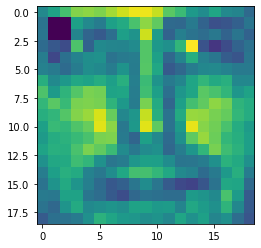

In [156]:
report_image = Image.open('dataset/trainset/faces/face00001.png')
img1 = ImageDraw.Draw(report_image)
x=viola.classifiers[2]
print(x)
for neg in x[1]:
    shape=[(neg[0],neg[1]),(neg[0]+neg[2],neg[1]+neg[3])]
    img1.rectangle(shape, fill ="blue")
imshow(np.asarray(report_image)) 